In [1]:
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    accuracy_score
)
from sklearn.preprocessing import label_binarize

import os, random
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import (
    convnext_tiny, ConvNeXt_Tiny_Weights,
    efficientnet_b0, EfficientNet_B0_Weights
)
import timm

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
# Paths
data_dir = r"C:/Users/ZA SEYAM/AgroSpectraNet/data/processed"

# Paths
train_dir = os.path.join(data_dir, "train")
val_dir   = os.path.join(data_dir, "validation")
test_dir  = os.path.join(data_dir, "test")

# Transforms (example, can be tuned)
transform_train = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_eval = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Datasets
train_ds = ImageFolder(train_dir, transform=transform_train)
val_ds   = ImageFolder(val_dir, transform=transform_eval)
test_ds  = ImageFolder(test_dir, transform=transform_eval)

# Classes
NUM_CLASSES = len(train_ds.classes)
print("Classes:", NUM_CLASSES, train_ds.classes[:5], "...")  # show sample

# Loaders
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

Classes: 30 ['corn_cercospora_leaf_spot', 'corn_common_rust', 'corn_healthy', 'corn_northern_leaf_blight', 'jute_cescospora_leaf_spot'] ...


In [3]:
class ConvNeXtV2_Tiny_Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        # ConvNeXt-V2 Tiny (features_only=False for classifier)
        self.convnext = timm.create_model('convnextv2_tiny', pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.convnext(x)

# Initialize
model = ConvNeXtV2_Tiny_Model(NUM_CLASSES).to(device)
print(model)

ConvNeXtV2_Tiny_Model(
  (convnext): ConvNeXt(
    (stem): Sequential(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (stages): Sequential(
      (0): ConvNeXtStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): ConvNeXtBlock(
            (conv_dw): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
            (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
            (mlp): GlobalResponseNormMlp(
              (fc1): Linear(in_features=96, out_features=384, bias=True)
              (act): GELU()
              (drop1): Dropout(p=0.0, inplace=False)
              (grn): GlobalResponseNorm()
              (fc2): Linear(in_features=384, out_features=96, bias=True)
              (drop2): Dropout(p=0.0, inplace=False)
            )
            (shortcut): Identity()
            (drop_path): Identity()
          )
          (1): Con

In [4]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=3)
scaler = GradScaler()   # ✅ AMP scaler

# --- Training function ---
def train_one_epoch(model, loader, optimizer, criterion, scaler, device):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(loader, desc="Training", leave=False)

    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad(set_to_none=True)

        # ✅ autocast for mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * inputs.size(0)
        _, preds = outputs.max(1)
        correct += preds.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / total, correct / total

# --- Evaluation function ---
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = outputs.max(1)
            correct += preds.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, correct / total

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_20692\1839667932.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()   # ✅ AMP scaler


In [5]:
EPOCHS = 30 
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0

for epoch in range(1, EPOCHS+1):
    print(f"\n===== Epoch {epoch}/{EPOCHS} =====")
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion, scaler, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    scheduler.step(val_loss)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Train Loss: {tr_loss:.4f} | Train Acc: {tr_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "ConveNeXt-V2.pt")
        print("💾 Saved Best Model")


===== Epoch 1/30 =====


Training:   0%|          | 0/807 [00:20<?, ?it/s]

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_20692\1839667932.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_20692\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 2.4143 | Train Acc: 0.2348
Val   Loss: 1.7756 | Val   Acc: 0.3484
💾 Saved Best Model

===== Epoch 2/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 1.4411 | Train Acc: 0.4732
Val   Loss: 1.0714 | Val   Acc: 0.5833
💾 Saved Best Model

===== Epoch 3/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.9181 | Train Acc: 0.6443
Val   Loss: 0.6457 | Val   Acc: 0.7427
💾 Saved Best Model

===== Epoch 4/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.6169 | Train Acc: 0.7697
Val   Loss: 0.5380 | Val   Acc: 0.7954
💾 Saved Best Model

===== Epoch 5/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.4752 | Train Acc: 0.8297
Val   Loss: 0.3915 | Val   Acc: 0.8504
💾 Saved Best Model

===== Epoch 6/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.3953 | Train Acc: 0.8591
Val   Loss: 0.4626 | Val   Acc: 0.8258

===== Epoch 7/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.3390 | Train Acc: 0.8832
Val   Loss: 0.3207 | Val   Acc: 0.8966
💾 Saved Best Model

===== Epoch 8/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.2942 | Train Acc: 0.8993
Val   Loss: 0.3532 | Val   Acc: 0.8825

===== Epoch 9/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.2481 | Train Acc: 0.9160
Val   Loss: 0.3155 | Val   Acc: 0.8999
💾 Saved Best Model

===== Epoch 10/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.2351 | Train Acc: 0.9197
Val   Loss: 0.2623 | Val   Acc: 0.9147
💾 Saved Best Model

===== Epoch 11/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.2077 | Train Acc: 0.9302
Val   Loss: 0.2329 | Val   Acc: 0.9277
💾 Saved Best Model

===== Epoch 12/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.1895 | Train Acc: 0.9365
Val   Loss: 0.2803 | Val   Acc: 0.9078

===== Epoch 13/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.1730 | Train Acc: 0.9415
Val   Loss: 0.2288 | Val   Acc: 0.9281
💾 Saved Best Model

===== Epoch 14/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.1547 | Train Acc: 0.9489
Val   Loss: 0.2850 | Val   Acc: 0.9172

===== Epoch 15/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.1468 | Train Acc: 0.9530
Val   Loss: 0.2245 | Val   Acc: 0.9313
💾 Saved Best Model

===== Epoch 16/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.1328 | Train Acc: 0.9582
Val   Loss: 0.2183 | Val   Acc: 0.9328
💾 Saved Best Model

===== Epoch 17/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.1158 | Train Acc: 0.9613
Val   Loss: 0.2117 | Val   Acc: 0.9400
💾 Saved Best Model

===== Epoch 18/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.1305 | Train Acc: 0.9585
Val   Loss: 0.2325 | Val   Acc: 0.9317

===== Epoch 19/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.1062 | Train Acc: 0.9668
Val   Loss: 0.2267 | Val   Acc: 0.9324

===== Epoch 20/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0889 | Train Acc: 0.9722
Val   Loss: 0.2791 | Val   Acc: 0.9263

===== Epoch 21/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.0998 | Train Acc: 0.9679
Val   Loss: 0.2256 | Val   Acc: 0.9266

===== Epoch 22/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0354 | Train Acc: 0.9892
Val   Loss: 0.1858 | Val   Acc: 0.9519
💾 Saved Best Model

===== Epoch 23/30 =====


Training:   0%|          | 0/807 [00:17<?, ?it/s]

Train Loss: 0.0350 | Train Acc: 0.9881
Val   Loss: 0.2296 | Val   Acc: 0.9378

===== Epoch 24/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.0288 | Train Acc: 0.9917
Val   Loss: 0.2056 | Val   Acc: 0.9501

===== Epoch 25/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.0297 | Train Acc: 0.9905
Val   Loss: 0.2237 | Val   Acc: 0.9469

===== Epoch 26/30 =====


Training:   0%|          | 0/807 [00:18<?, ?it/s]

Train Loss: 0.0287 | Train Acc: 0.9913
Val   Loss: 0.2092 | Val   Acc: 0.9458

===== Epoch 27/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0112 | Train Acc: 0.9966
Val   Loss: 0.1856 | Val   Acc: 0.9559
💾 Saved Best Model

===== Epoch 28/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0046 | Train Acc: 0.9988
Val   Loss: 0.2066 | Val   Acc: 0.9541

===== Epoch 29/30 =====


Training:   0%|          | 0/807 [00:15<?, ?it/s]

Train Loss: 0.0053 | Train Acc: 0.9983
Val   Loss: 0.2449 | Val   Acc: 0.9516

===== Epoch 30/30 =====


Training:   0%|          | 0/807 [00:16<?, ?it/s]

Train Loss: 0.0115 | Train Acc: 0.9966
Val   Loss: 0.2637 | Val   Acc: 0.9472


✅ Training curves saved at: C:/Users/ZA SEYAM/AgroSpectraNet/results/CNV-2_training_curves.png


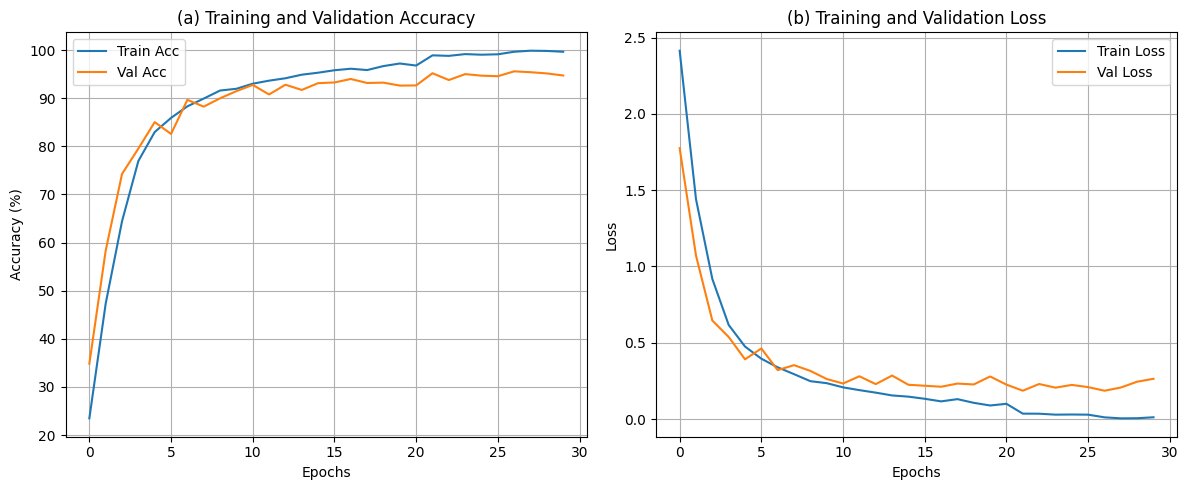

In [11]:
# Plot Training & Validation Curves (Accuracy in %)
def plot_curves(history, save_path="training_curves.png"):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # (a) Accuracy subplot (converted to percentage)
    axes[0].plot([acc * 100 for acc in history["train_acc"]], label="Train Acc")
    axes[0].plot([acc * 100 for acc in history["val_acc"]], label="Val Acc")
    axes[0].set_title("(a) Training and Validation Accuracy", fontsize=12)
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy (%)")
    axes[0].legend()
    axes[0].grid(True)

    # (b) Loss subplot (keeps original scale)
    axes[1].plot(history["train_loss"], label="Train Loss")
    axes[1].plot(history["val_loss"], label="Val Loss")
    axes[1].set_title("(b) Training and Validation Loss", fontsize=12)
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.tight_layout()

    # Save figure
    plt.savefig(save_path, dpi=300, bbox_inches="tight")
    print(f"✅ Training curves saved at: {save_path}")

    # Show figure
    plt.show()


# Example usage
plot_curves(history, save_path="C:/Users/ZA SEYAM/AgroSpectraNet/results/CNV-2_training_curves.png")

In [10]:
# Load best model
model.load_state_dict(torch.load("ConveNeXt-V2.pt"))

# Final evaluation
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nFinal Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

C:\Users\ZA SEYAM\AppData\Local\Temp\ipykernel_20692\1839667932.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():



Final Test Loss: 0.2435 | Final Test Acc: 0.9471
